<center>
<h2> Pricing Options Using Machine Learning Algorithms </h2>
<h2> By : Youssef BULAHIA </h2>

<h4> Data Generation : </h4>

In [1]:
# Data Generation

import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(100)

# Number od samples
n_samples = 100000

# Generating random parameters for the options
S = np.random.uniform(50, 150, n_samples) # Spot price : Between $50 and $150
K = np.random.uniform(50, 150, n_samples) # Strike Price : Between $50 and $150
T = np.random.uniform(0.25, 2, n_samples) # Time to Maturity : Between 3 months and 2 years
r = np.random.uniform(0.01, 0.05, n_samples) # Risk-free Rate : Between 1% and 5%

# Introducing volatility skew : Options with lower strike prices will tend to have higher volatilities
sigma = np.random.uniform(0.1, 0.4, n_samples) + (K < S) * np.random.uniform(0.05, 0.15, n_samples)

# Creating a DataFrame to store these values
options_df = pd.DataFrame({
    'Spot_Price' : S,
    'Strike_Price' : K,
    'Time_to_Maturity' : T,
    'Risk_free_Rate' : r,
    'Volatility' : sigma
})

options_df.head()

,Spot_Price,Strike_Price,Time_to_Maturity,Risk_free_Rate,Volatility
0,104.340494,95.713380,1.055862,0.047854,0.278071
1,77.836939,141.016933,0.637673,0.044817,0.229191
2,92.451759,88.909593,1.163595,0.018623,0.239848
3,134.477613,107.886900,0.807283,0.017973,0.472237
4,50.471886,86.523635,1.302674,0.031568,0.287524


<h4> Option Pricing : </h4>

In [2]:
from scipy.stats import norm

def black_scholes_put_prices(S, K, T, r, sigma, q = 0) :
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
    return put_price

options_df['BS_Put_Price'] = black_scholes_put_prices(
    options_df['Spot_Price'],
    options_df['Strike_Price'],
    options_df['Time_to_Maturity'],
    options_df['Risk_free_Rate'],
    options_df['Volatility'])

options_df[['Spot_Price', 'Strike_Price', 'Volatility', 'BS_Put_Price']].head()

,Spot_Price,Strike_Price,Volatility,BS_Put_Price
0,104.340494,95.713380,0.278071,5.661593
1,77.836939,141.016933,0.229191,59.212146
2,92.451759,88.909593,0.239848,6.763351
3,134.477613,107.886900,0.472237,9.116216
4,50.471886,86.523635,0.287524,33.158638


<h4> Volatility Skew Adjustment : </h4>

In [3]:
# Adjusting the volatility skew based on how far OTM the option is and the magnitude of the strike price
delta_from_ATM = (options_df['Spot_Price'] - options_df['Strike_Price']).abs()
skew_factor = np.where(options_df['Strike_Price'] < options_df['Spot_Price'], delta_from_ATM / options_df['Strike_Price'], 0)

# Adjusting the volatility to introduce a more pronounced skew for OTM options and options with smaller strike prices
options_df['Adjusted_Volatility'] = options_df['Volatility'] + skew_factor * np.random.uniform(0.05, 0.2, n_samples)

# Compute put option prices using Black-Scholes formula with adjusted volatility
options_df['Adjusted_BS_Put_Price'] = black_scholes_put_prices(
    options_df['Spot_Price'],
    options_df['Strike_Price'],
    options_df['Time_to_Maturity'],
    options_df['Risk_free_Rate'],
    options_df['Adjusted_Volatility'])

options_df[['Spot_Price', 'Strike_Price', 'Volatility', 'BS_Put_Price', 'Adjusted_BS_Put_Price']].head()

,Spot_Price,Strike_Price,Volatility,BS_Put_Price,Adjusted_BS_Put_Price
0,104.340494,95.713380,0.278071,5.661593,6.172431
1,77.836939,141.016933,0.229191,59.212146,59.212146
2,92.451759,88.909593,0.239848,6.763351,6.866005
3,134.477613,107.886900,0.472237,9.116216,10.042978
4,50.471886,86.523635,0.287524,33.158638,33.158638


<h4> Data Splitting : </h4>

In [4]:
from sklearn.model_selection import train_test_split

# Features and target variable
X = options_df[['Spot_Price', 'Strike_Price', 'Time_to_Maturity', 'Risk_free_Rate', 'Volatility']]
y = options_df['Adjusted_BS_Put_Price']

#Splitting the data into training and testing sets(80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 100)
X_train.shape, X_test.shape

((80000, 5), (20000, 5))

<h4> Machine Learning Models : </h4>

<h7> Linear Regression Model : </h7>

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

#Predict on the test set
lr_predictions = lr_model.predict(X_test)

# Compute accuracy metrics
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

lr_mse, lr_mae, lr_r2

(82.795481764439, 7.3804529142429125, 0.80296141968596)

<h7> Decision Tree Regressor : </h7>

In [6]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state = 100)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
dt_predictions = dt_model.predict(X_test)

# Compute accuracy metrics
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

dt_mse, dt_mae, dt_r2

(2.248886116390557, 1.1068937522483848, 0.9946480494077894)

<h7> Random Forest Regressor : </h7>

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators = 100, random_state = 100)

# Train the model
rf_model.fit(X_train, y_train)

#Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Compute accuracy metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

rf_mse, rf_mae, rf_r2

(0.6051121538944594, 0.5767870581154975, 0.9985599402625212)

<h7> Gradient Boosted Trees Regressor : </h7>

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state = 100)

# Train the model
gb_model.fit(X_train, y_train)

# Predict on the test set
gb_predictions = gb_model.predict(X_test)

# Compute accuracy metrics
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

gb_mse, gb_mae, gb_r2

(3.0556587258842005, 1.3764935952838029, 0.9927280735078586)

<h7> Neural Network (MLP) Regressor : </h7>

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Neural networks benefit from feature scaling. So, we'll scale out our features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Neural Network (MLP) model
nn_model = MLPRegressor(hidden_layer_sizes = (100, 50), max_iter = 1000, random_state = 100)

# Train the model
nn_model.fit(X_train_scaled, y_train)

# Predict on the test set
nn_predictions = nn_model.predict(X_test_scaled)

# Compute accuracy metrics
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, gb_predictions)

nn_mse, nn_mae, nn_r2

(0.11300457733907915, 0.19965639893943593, 0.9927280735078586)

<h4> Summary of Model Prformance  : </h4>

In [10]:
import pandas as pd

# Constructing the results dataframe
results_df = pd.DataFrame({
    'Model' : ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees', 'Neural Network (MLP)'],
    'Mean Squared Error' : [lr_mse, dt_mse, rf_mse, gb_mse, nn_mse],
    'Mean Absolute Error' : [lr_mae, dt_mae, rf_mae, gb_mae, nn_mae],
    'R-squared' : [lr_r2, dt_r2, rf_r2, gb_r2, nn_r2]
})

results_df

,Model,Mean Squared Error,Mean Absolute Error,R-squared
0,Linear Regression,82.795482,7.380453,0.802961
1,Decision Tree,2.248886,1.106894,0.994648
2,Random Forest,0.605112,0.576787,0.998560
3,Gradient Boosted Trees,3.055659,1.376494,0.992728
4,Neural Network (MLP),0.113005,0.199656,0.992728


<h7> Scatter Plots of Actual vs. Predicted Option Prices : </h7>

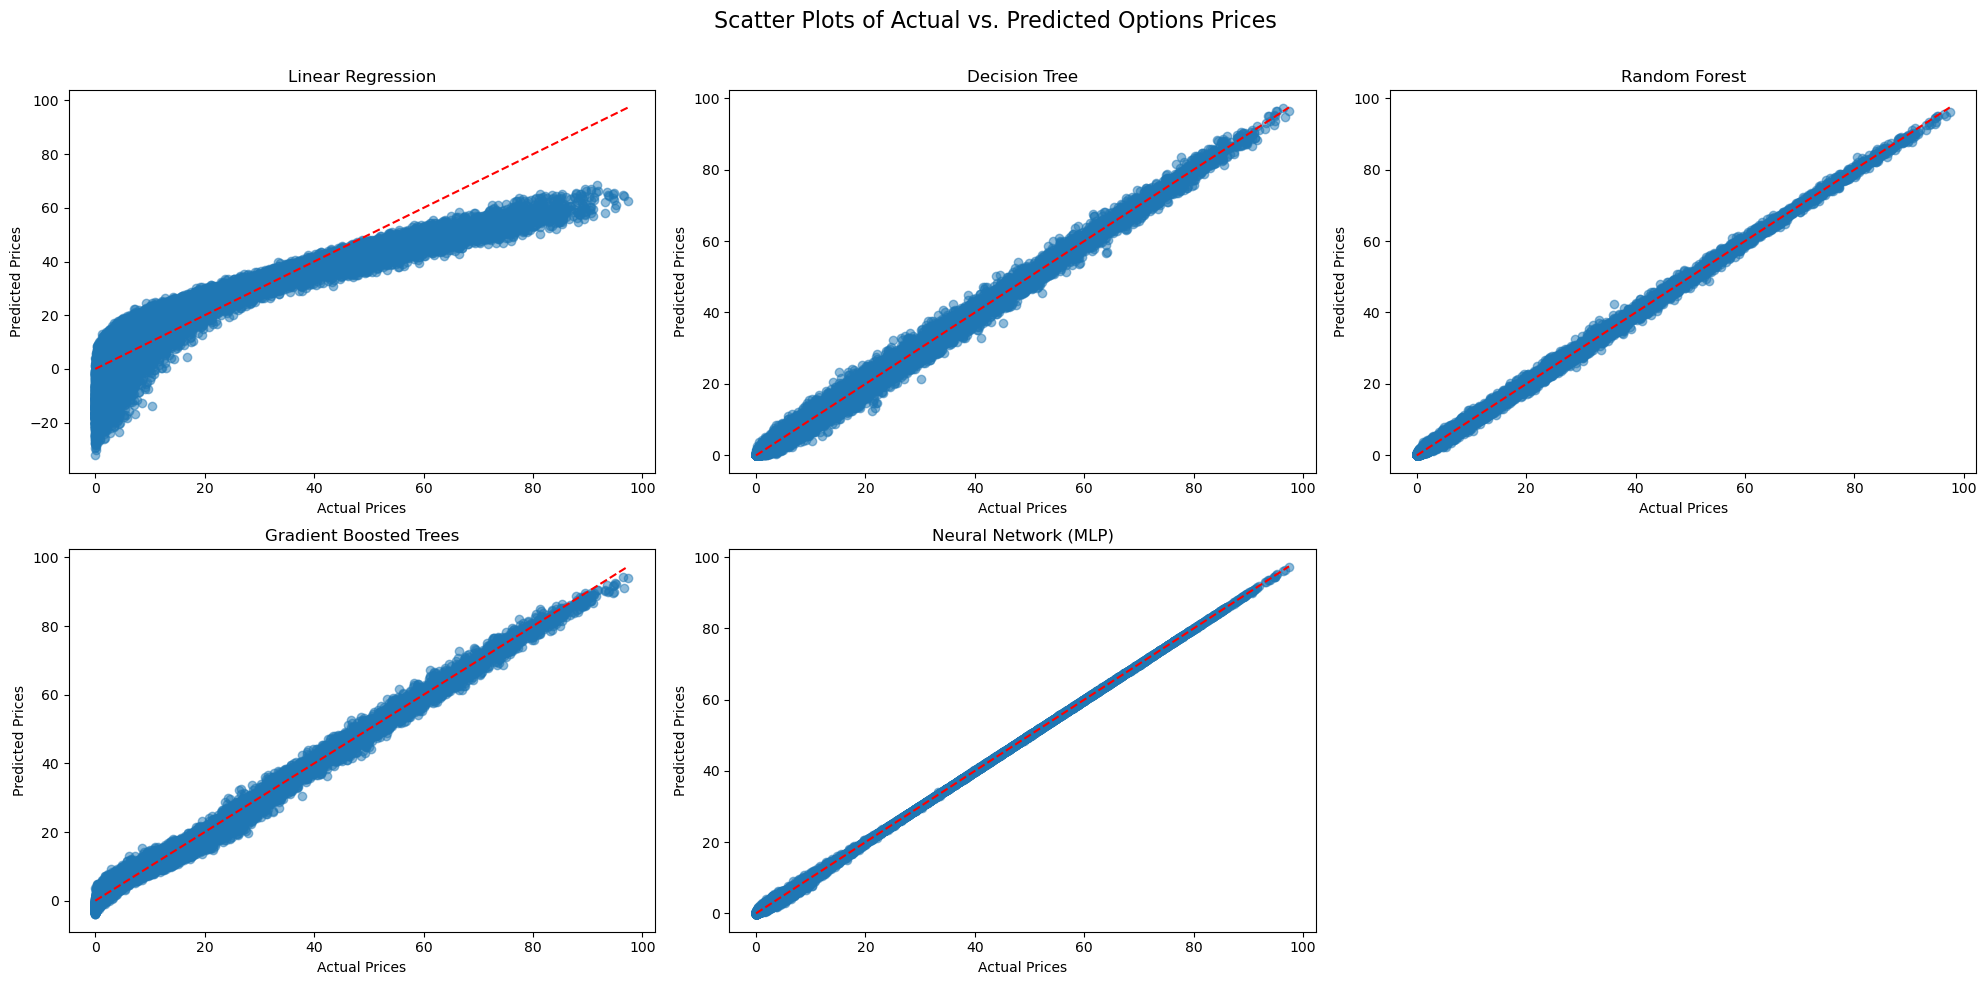

In [11]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Scatter Plots of Actual vs. Predicted Options Prices', fontsize = 16)

# Linear Regression Scatter Plot
axs[0, 0].scatter(y_test, lr_predictions, alpha=0.5)
axs[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].set_xlabel('Actual Prices')
axs[0, 0].set_ylabel('Predicted Prices')

# Decision Tree Scatter Plot
axs[0, 1].scatter(y_test, dt_predictions, alpha=0.5)
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[0, 1].set_title('Decision Tree')
axs[0, 1].set_xlabel('Actual Prices')
axs[0, 1].set_ylabel('Predicted Prices')

# Random Forest Scatter Plot
axs[0, 2].scatter(y_test, rf_predictions, alpha=0.5)
axs[0, 2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[0, 2].set_title('Random Forest')
axs[0, 2].set_xlabel('Actual Prices')
axs[0, 2].set_ylabel('Predicted Prices')

# Gradient Boosted Trees Scatter Plot
axs[1, 0].scatter(y_test, gb_predictions, alpha=0.5)
axs[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[1, 0].set_title('Gradient Boosted Trees')
axs[1, 0].set_xlabel('Actual Prices')
axs[1, 0].set_ylabel('Predicted Prices')

# Neural Network Scatter Plot
axs[1, 1].scatter(y_test, nn_predictions, alpha=0.5)
axs[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[1, 1].set_title('Neural Network (MLP)')
axs[1, 1].set_xlabel('Actual Prices')
axs[1, 1].set_ylabel('Predicted Prices')

# Hide the empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()